In [ ]:
import warnings

import dill

# Data Manipulation
import pandas as pd
import numpy as np

# Imputation - RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Transformation
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics
import math
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score

# Regression Algorithms
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor

%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')  # Disabling warning outputs

In [10]:
# Path to the CSV data file 
# Reading data from the CSV file into a DataFrame using the first column as the index
df = pd.read_csv(r'..\datasets\dynamic_pricing.csv')  


# Displaying the first few rows of the DataFrame
df.head()

Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                      43   
2       Afternoon      Premium                      76   
3       Afternoon      Premium                     134   
4       Afternoon      Economy                     149   

   Historical_Cost_of_Ride  
0               284.257273  
1               173.874753  
2               329.795469  
3               470.201232  
4               579.681422

In [11]:
# Initialize empty lists to store object and non-object columns
obj = []
ints = []

# Loop through DataFrame columns
for col in df.columns:
    # Check if column data type is object
    if df[col].dtype == 'object':
        # If object, append column name, unique values count, and count of missing values to 'obj' list
        obj.append((col, df[col].nunique(), df[col].isna().sum()))
    else:
        # If non-object, append column name, unique values count, and count of missing values to 'ints' list
        ints.append((col, df[col].nunique(), df[col].isna().sum(), df[col].skew()))

# Determine the maximum length of 'obj' and 'ints' lists
max_len = max(len(obj), len(ints))

# Extend 'obj' and 'ints' lists with empty tuples to match the maximum length
obj.extend([('', '', '')] * (max_len - len(obj)))
ints.extend([('', '', '', '')] * (max_len - len(ints)))

# Create a dictionary with keys representing column categories and values representing lists of corresponding data
data = {
    'Categorical_columns': [x[0] for x in obj],
    'cat_cols_uniques': [x[1] for x in obj],
    'cat_cols_missing': [x[2] for x in obj],
    'Numeric_columns': [x[0] for x in ints],
    'int_cols_uniques': [x[1] for x in ints],
    'int_cols_missing': [x[2] for x in ints],
    'int_cols_skew': [x[3] for x in ints]
}

# Convert the dictionary into a pandas DataFrame
pd.DataFrame(data)

Categorical_columns cat_cols_uniques cat_cols_missing  \
0        Location_Category                3                0   
1  Customer_Loyalty_Status                3                0   
2          Time_of_Booking                4                0   
3             Vehicle_Type                2                0   
4                                                              
5                                                              

           Numeric_columns  int_cols_uniques  int_cols_missing  int_cols_skew  
0         Number_of_Riders                81                 0       0.002167  
1        Number_of_Drivers                79                 0       0.963204  
2     Number_of_Past_Rides               101                 0      -0.008457  
3          Average_Ratings               151                 0      -0.078754  
4   Expected_Ride_Duration               171                 0      -0.139868  
5  Historical_Cost_of_Ride              1000                 0       0.209580

In [12]:
# This line of code retrieves the shape of the DataFrame 'df'
shape = df.shape
print(shape)

(1000, 10)


In [13]:
# Displaying concise summary information about the DataFrame, including
# data types, non-null values, and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [14]:
# Displaying the data types of each column in the DataFrame
df.dtypes

Number_of_Riders             int64
Number_of_Drivers            int64
Location_Category           object
Customer_Loyalty_Status     object
Number_of_Past_Rides         int64
Average_Ratings            float64
Time_of_Booking             object
Vehicle_Type                object
Expected_Ride_Duration       int64
Historical_Cost_of_Ride    float64
dtype: object

In [15]:
# Counting the number of duplicated rows in the DataFrame and then counting
# the frequency of those counts to summarize the distribution of duplicated rows
df.duplicated().value_counts()

False    1000
Name: count, dtype: int64

In [16]:
df.columns

Index(['Number_of_Riders', 'Number_of_Drivers', 'Location_Category',
       'Customer_Loyalty_Status', 'Number_of_Past_Rides', 'Average_Ratings',
       'Time_of_Booking', 'Vehicle_Type', 'Expected_Ride_Duration',
       'Historical_Cost_of_Ride'],
      dtype='object')

In [17]:
# Exploratory Data Analysis
# Generate descriptive statistics for all numerical columns
df.describe()

Number_of_Riders  Number_of_Drivers  Number_of_Past_Rides  \
count       1000.000000        1000.000000           1000.000000   
mean          60.372000          27.076000             50.031000   
std           23.701506          19.068346             29.313774   
min           20.000000           5.000000              0.000000   
25%           40.000000          11.000000             25.000000   
50%           60.000000          22.000000             51.000000   
75%           81.000000          38.000000             75.000000   
max          100.000000          89.000000            100.000000   

       Average_Ratings  Expected_Ride_Duration  Historical_Cost_of_Ride  
count      1000.000000              1000.00000              1000.000000  
mean          4.257220                99.58800               372.502623  
std           0.435781                49.16545               187.158756  
min           3.500000                10.00000                25.993449  
25%           3.870000                59.75000               221.365202  
50%           4.270000               102.00000               362.019426  
75%           4.632500               143.00000               510.497504  
max           5.000000               180.00000               836.116419

In [18]:
# Generate descriptive statistics for categorical columns
df.describe(include='object')

Location_Category Customer_Loyalty_Status Time_of_Booking Vehicle_Type
count               1000                    1000            1000         1000
unique                 3                       3               4            2
top                Urban                  Silver           Night      Premium
freq                 346                     367             276          522

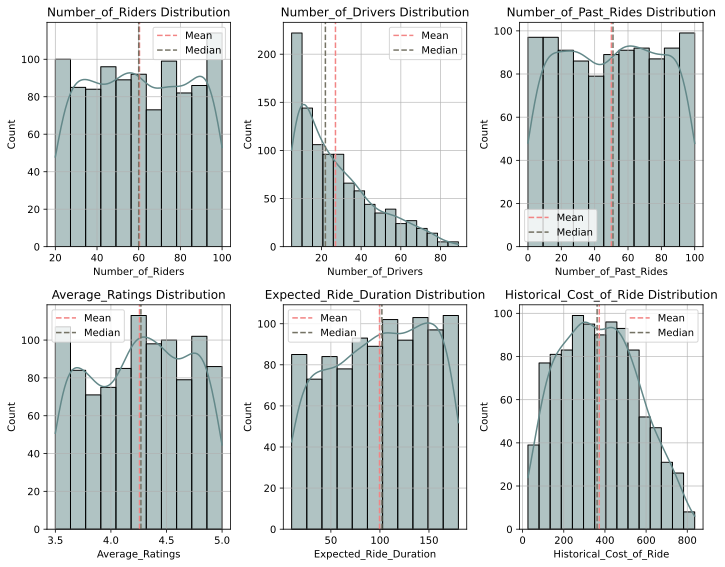

In [19]:
# Visualising Categorical and Numerical features distributions

# Select numerical columns from the DataFrame
numerics = df.select_dtypes(include='number')

# Calculate the number of plots, rows, and columns for subplots
num_plots = len(numerics.columns)
num_columns = 3
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0)



# Set the figure size based on the number of rows
plt.figure(figsize=(10, 4 * num_rows))

# Iterate over each numerical column and create a histogram subplot
for i, col in enumerate(numerics, 1):
    plt.subplot(num_rows, num_columns, i)  # Create subplot
    mean_values = numerics[col].mean()
    median = numerics[col].median()

    sns.histplot(numerics[col], kde=True, color='#638889')  # Plot histogram using seaborn
    plt.axvline(x=mean_values, color='#F28585', linestyle='--', label='Mean')
    plt.axvline(x=median, color='#747264', linestyle='--', label='Median')
    plt.grid(True, alpha=0.8)  # Add grid lines to the plot
    plt.title(f'{col} Distribution')  # Set title for the subplot
    plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plots

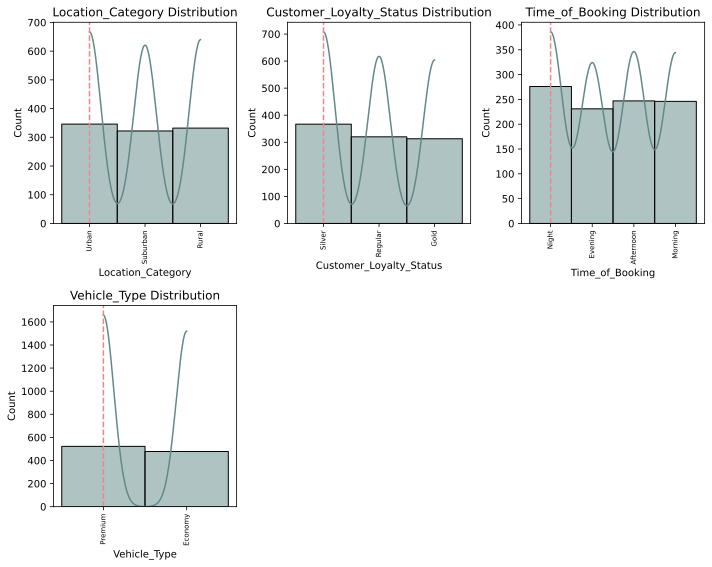

In [20]:
# Select categorical columns from the DataFrame
categorical_cols = df.select_dtypes(include=['object']).columns

# Calculate the number of plots, rows, and columns for subplots
num_plots = len(categorical_cols)
num_columns = 3
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0)

# Set the figure size based on the number of rows
plt.figure(figsize=(10, 4 * num_rows))

# Iterate over each categorical column and create a histogram subplot
for i, col in enumerate(df[categorical_cols], 1):
    mode = df[col].mode()[0]    
    plt.subplot(num_rows, num_columns, i)  # Create subplot
    sns.histplot(df[col], kde=True, color='#638889')  # Plot histogram using seaborn

    plt.axvline(x=mode, color='#F28585', linestyle='--', label='Mode')

    plt.xticks(rotation=90, fontsize=7)  # Rotate x-axis labels for better readability
    plt.title(f'{col} Distribution')  # Set title for the subplot

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plots

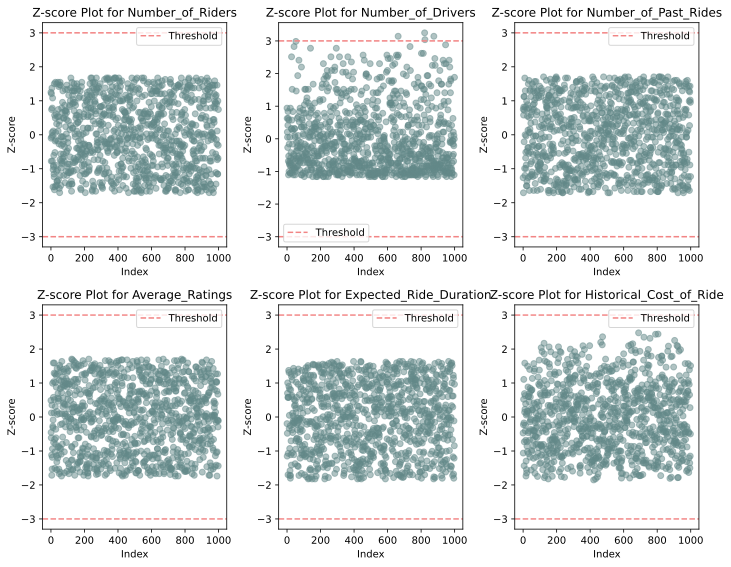

In [21]:
numerics = df.select_dtypes(include=np.number)

# Calculate the number of plots, rows, and columns for subplots
num_plots = len(numerics.columns)
num_columns = 3
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0)

# Set the figure size based on the number of rows
plt.figure(figsize=(10, 4 * num_rows))

for i, col in enumerate(numerics, 1):
    plt.subplot(num_rows, num_columns, i)  
    z_scores = (numerics[col] - numerics[col].mean()) / numerics[col].std()

    threshold = 3

    plt.scatter(np.arange(len(z_scores)), z_scores, color='#638889', alpha=0.5)
    plt.axhline(y=threshold, color='#F28585', linestyle='--', label='Threshold')
    plt.axhline(y=-threshold, color='#F28585', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Z-score')
    plt.title(f'Z-score Plot for {col}')
    plt.legend()

plt.tight_layout()
plt.show()

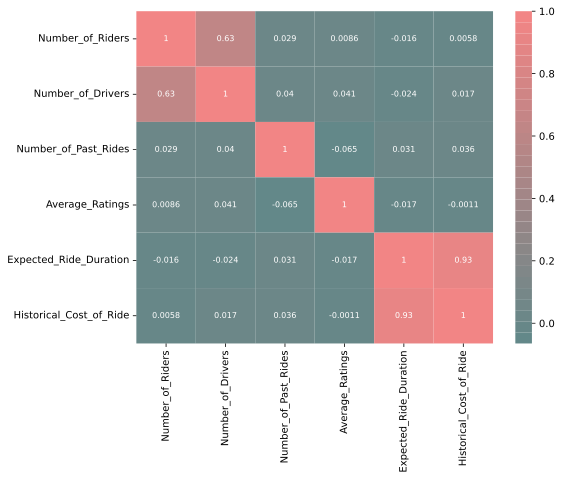

In [22]:
# Visualising correlation

# Set the figure size
plt.figure(figsize=(8, 6))

# Create a heatmap of the correlation matrix for numerical columns in the dataframe
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, 
            cmap=['#638889', '#678788', '#6c8788', '#718788', '#768788',
                  '#7b8788', '#808788', '#858788', '#8a8787', '#8f8787',
                  '#948687', '#998687', '#9e8687', '#a38687', '#a88687',
                  '#ac8686', '#b18686', '#b68686', '#bb8686', '#c08686',
                  '#c58586', '#ca8586', '#cf8585', '#d48585', '#d98585',
                  '#de8585', '#e38585', '#e88585', '#ed8585', '#f28585'], annot_kws={"fontsize":8})

# Show the plot
plt.show()

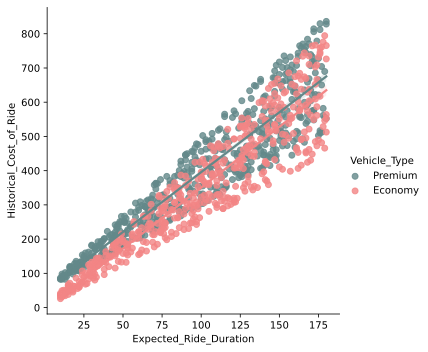

In [23]:
# Create a scatter plot with linear regression lines using seaborn's lmplot
sns.lmplot(data=df, y='Historical_Cost_of_Ride', x='Expected_Ride_Duration', hue='Vehicle_Type', 
           palette=['#638889', '#f28585'])

# Show the plot
plt.show()

In [24]:
# Dynamic price calc

# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

df['demand_multiplier'] = np.where(df['Number_of_Riders'] > np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                   df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                   df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], low_demand_percentile))

# Calculate supply_multiplier based on percentile for high and low supply
high_supply_percentile = 75
low_supply_percentile = 25

df['supply_multiplier'] = np.where(df['Number_of_Drivers'] > np.percentile(df['Number_of_Drivers'], 
                                                                           low_supply_percentile),
                                   np.percentile(df['Number_of_Drivers'], high_supply_percentile)
                                   / df['Number_of_Drivers'], np.percentile(df['Number_of_Drivers'], 
                                                                            low_supply_percentile) 
                                   / df['Number_of_Drivers'])

# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8  # Lower demand threshold
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low = 1.2  # Lower supply threshold

# Calculate adjusted_ride_cost for dynamic pricing
df['adjusted_ride_cost'] = df['Historical_Cost_of_Ride'] * (
    np.maximum(df['demand_multiplier'], demand_threshold_low) *
    np.maximum(df['supply_multiplier'], supply_threshold_high)
)

In [25]:
df.head()

Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                      43   
2       Afternoon      Premium                      76   
3       Afternoon      Premium                     134   
4       Afternoon      Economy                     149   

   Historical_Cost_of_Ride  demand_multiplier  supply_multiplier  \
0               284.257273           1.111111           0.844444   
1               173.874753           1.450000           0.974359   
2               329.795469           1.050000           1.225806   
3               470.201232           1.098765           1.357143   
4               579.681422           1.950000           1.727273   

   adjusted_ride_cost  
0          266.710528  
1          245.653817  
2          424.478684  
3          701.155452  
4         1952.472427

In [26]:
# Profability Analysis of rides

# Calculate the profit percentage for each ride
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) 
                           / df['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = df[df['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = df[df['profit_percentage'] < 0]

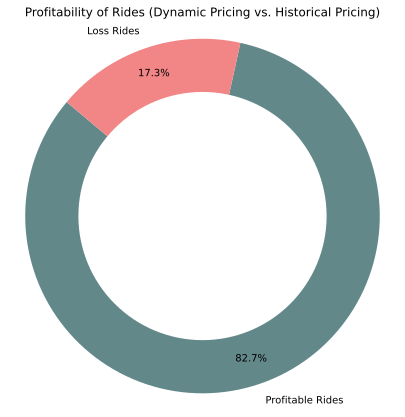

In [27]:
# Calculate the profit percentage for each ride
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) 
                           / df['Historical_Cost_of_Ride']) * 100
# Identify profitable rides where profit percentage is positive
profitable_rides = df[df['profit_percentage'] > 0]

# Identify loss rides where profit percentage is negative
loss_rides = df[df['profit_percentage'] < 0]

# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

plt.figure(figsize=(7, 7))

# Create a pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, 
        colors = ['#638889', '#f28585'], labeldistance = 1.1,
                  pctdistance = 0.85, normalize=True
)

# Draw a circle in the center to create a ring
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title('Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')


plt.show()

In [28]:
# Calculate the skewness of the target variable 'TARGET' and round the result to 2 decimal places
print("Skewness: ", round(df['adjusted_ride_cost'].skew(), 2))

Skewness:  1.58


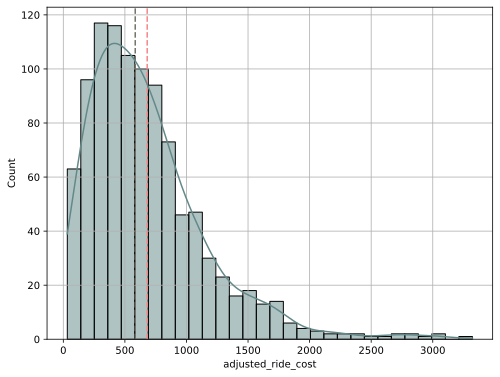

In [29]:
# Create a new figure with a specified size (8 inches width, 6 inches height)
plt.figure(figsize=(8, 6))


# Calculate the mean and median of the 'adjusted_ride_cost' column
mean_values = df['adjusted_ride_cost'].mean()
median = df['adjusted_ride_cost'].median()

# Add vertical lines for mean and median to the plot
plt.axvline(x=mean_values, color='#F28585', linestyle='--', label='Mean')
plt.axvline(x=median, color='#747264', linestyle='--', label='Median')

# Create a histogram plot with KDE (Kernel Density Estimation)
sns.histplot(df['adjusted_ride_cost'], kde=True, color='#638889')

# Add grid lines to the plot
plt.grid(True)

# Display the plot
plt.show()

In [30]:
# Apply the natural logarithm transformation plus 1 to the target variable 'TARGET'
df['adjusted_ride_cost'] = np.log1p(df['adjusted_ride_cost'])

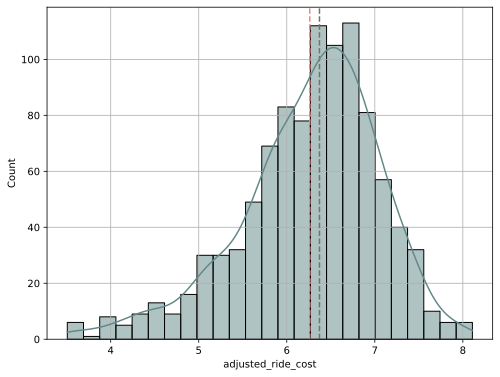

In [31]:
# Create a new figure with a specified size (8 inches width, 6 inches height)
plt.figure(figsize=(8, 6))

# Calculate the mean and median of the 'adjusted_ride_cost' column
mean_value = df['adjusted_ride_cost'].mean()
median = df['adjusted_ride_cost'].median()

# Plot vertical lines indicating mean and median on the histogram plot
plt.axvline(x=mean_value, color='#F28585', linestyle='--', label='Mean')
plt.axvline(x=median, color='#747264', linestyle='--', label='Median')

# Create a histogram plot with KDE (Kernel Density Estimation)
sns.histplot(df['adjusted_ride_cost'], kde=True, color='#638889')

# Add grid lines to the plot
plt.grid(True)

# Display the plot
plt.show()

In [32]:
# Calculate the skewness of the transformed target variable 'TARGET' and round the result to 2 decimal places
print("Skewness: ", round(df['adjusted_ride_cost'].skew(), 2))

Skewness:  -0.72


In [33]:
# Print the skewness of the transformed 'Number_of_Drivers' column
print("Skewness: ", round(df['Number_of_Drivers'].skew(), 2))

Skewness:  0.96


In [34]:
# Estimate the optimal Box-Cox transformation parameter lambda for 'Number_of_Drivers' column
lambda_est = boxcox_normmax(df['Number_of_Drivers'] + 2, brack=(-1.5, 1.5))

# Apply the Box-Cox transformation to the 'Number_of_Drivers' column using the estimated lambda
df['Number_of_Drivers'] = boxcox1p(df['Number_of_Drivers'], lambda_est)

# Print the skewness of the transformed 'Number_of_Drivers' column
print("Skewness: ", round(df['Number_of_Drivers'].skew(), 2))

Skewness:  -0.01


In [35]:
# Data splitting

# Create the TRAIN subset by selecting rows where the target variable TARGET is not null
TARGET = df['adjusted_ride_cost']

# Create the TEST subset by selecting rows where the target variable TARGET is null
df = df.drop(columns=['adjusted_ride_cost'])

In [36]:
# Count the number of columns for each data type and display the counts
df.dtypes.value_counts()

float64    6
object     4
int64      3
Name: count, dtype: int64

In [37]:
df['Vehicle_Type'] = df['Vehicle_Type'].map({'Economy': 0, 'Premium': 1})

# Assign the feature matrix X to the TRAIN DataFrame
X = df[['Number_of_Riders', 'Number_of_Drivers', 'Expected_Ride_Duration', 'Vehicle_Type']]


# Подгоняем полином к набору данных
coefficients = np.polyfit(X['Number_of_Riders'].values, X['Number_of_Drivers'].values, deg=2)

# Создаем полином на основе коэффициентов
poly = np.poly1d(coefficients)

# Вычисляем значения полинома для нового признака
division_feature = poly(X['Number_of_Riders'].values / X['Number_of_Drivers'].values)


# Преобразуем результат обратно в Series
X['interpolated_division'] = pd.Series(division_feature)

In [ ]:
# Standardizing Features with StandardScaler